# Olist — EDA auto-détectée

Ce notebook détecte automatiquement les noms réels des tables/colonnes (orders, order_items, etc.) dans `olist.db`.
Il évite les messages "Table ... absente" quand les noms diffèrent.


## 0) Connexion & liste des tables

In [1]:
import os, sqlite3, pandas as pd, numpy as np, re, matplotlib.pyplot as plt, pathlib
DB_PATH = "olist.db"
print("cwd:", os.getcwd()); print("db exists:", os.path.exists(DB_PATH))
conn = sqlite3.connect(DB_PATH)
tables = pd.read_sql_query("SELECT name AS table_name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%' ORDER BY name;", conn)
display(tables)
pathlib.Path("outputs/eda_auto").mkdir(parents=True, exist_ok=True)
tables.to_csv("outputs/eda_auto/_tables_list.csv", index=False)

cwd: /home/11abf27e-0cc0-465b-a07f-1c938a9ee568
db exists: True


,table_name
0,customers
1,geoloc
2,order_items
3,order_pymts
4,order_reviews
5,orders
6,products
7,sellers
8,translation


## 1) Auto-détection des tables & colonnes

In [2]:
def find_table(candidates, names):
    for cand in candidates:
        if cand in names: return cand
    for n in names:
        for cand in candidates:
            if cand in n: return n
    return None
def best_col(cols, candidates):
    for c in candidates:
        if c in cols: return c
    for c in candidates:
        for col in cols:
            if c in col: return col
    return None

names = tables['table_name'].tolist()
orders_t    = find_table(["olist_orders_dataset","orders","olist_orders","order"], names)
items_t     = find_table(["olist_order_items_dataset","order_items","olist_order_items","items"], names)
customers_t = find_table(["olist_customers_dataset","customers","olist_customers","customer"], names)
reviews_t   = find_table(["olist_order_reviews_dataset","order_reviews","olist_order_reviews","reviews"], names)
sellers_t   = find_table(["olist_sellers_dataset","sellers","olist_seller","seller"], names)
products_t  = find_table(["olist_products_dataset","products","olist_products","product"], names)

def cols_of(t):
    import pandas as pd
    return pd.read_sql_query(f"PRAGMA table_info('{t}')", conn)['name'].tolist() if t else []

orders_cols   = cols_of(orders_t)
items_cols    = cols_of(items_t)
customers_cols= cols_of(customers_t)
reviews_cols  = cols_of(reviews_t)
sellers_cols  = cols_of(sellers_t)
products_cols = cols_of(products_t)

order_id_col        = best_col(orders_cols,    ["order_id","id"])
customer_id_col     = best_col(orders_cols,    ["customer_id","buyer_id","customer"])
order_status_col    = best_col(orders_cols,    ["order_status","status"])
purchase_ts_col     = best_col(orders_cols,    ["order_purchase_timestamp","purchase_timestamp","purchase_date","created_at"])
delivered_date_col  = best_col(orders_cols,    ["order_delivered_customer_date","delivered_customer_date","delivered_date"])
eta_date_col        = best_col(orders_cols,    ["order_estimated_delivery_date","estimated_delivery_date","delivery_estimate"])

item_order_id_col   = best_col(items_cols,     ["order_id","order"])
price_col           = best_col(items_cols,     ["price","item_price","total_price"])
freight_col         = best_col(items_cols,     ["freight_value","shipping_cost","freight"])
seller_id_col       = best_col(items_cols,     ["seller_id","seller"])
product_id_col      = best_col(items_cols,     ["product_id","product"])

cust_zip_col        = best_col(customers_cols, ["customer_zip_code_prefix","zip_code_prefix","zip","zipcode","postal_code"])
cust_city_col       = best_col(customers_cols, ["customer_city","city"])
cust_state_col      = best_col(customers_cols, ["customer_state","state"])

review_score_col    = best_col(reviews_cols,   ["review_score","score"])
review_creation_col = best_col(reviews_cols,   ["review_creation_date","review_answer_timestamp","creation"])
review_order_id_col = best_col(reviews_cols,   ["order_id","order"])

seller_zip_col      = best_col(sellers_cols,   ["seller_zip_code_prefix","zip_code_prefix","zip","zipcode","postal_code"])
seller_city_col     = best_col(sellers_cols,   ["seller_city","city"])
seller_state_col    = best_col(sellers_cols,   ["seller_state","state"])

product_cat_col     = best_col(products_cols,  ["product_category_name","category"])

det_tables = pd.Series({"orders_t":orders_t,"items_t":items_t,"customers_t":customers_t,"reviews_t":reviews_t,"sellers_t":sellers_t,"products_t":products_t}, name="detected_tables")
det_cols = pd.Series({
    "order_id_col":order_id_col, "customer_id_col":customer_id_col, "order_status_col":order_status_col,
    "purchase_ts_col":purchase_ts_col, "delivered_date_col":delivered_date_col, "eta_date_col":eta_date_col,
    "item_order_id_col":item_order_id_col, "price_col":price_col, "freight_col":freight_col,
    "seller_id_col":seller_id_col, "product_id_col":product_id_col,
    "cust_zip_col":cust_zip_col, "cust_city_col":cust_city_col, "cust_state_col":cust_state_col,
    "review_score_col":review_score_col, "review_creation_col":review_creation_col, "review_order_id_col":review_order_id_col,
    "seller_zip_col":seller_zip_col, "seller_city_col":seller_city_col, "seller_state_col":seller_state_col,
    "product_cat_col":product_cat_col
}, name="detected_columns")
display(det_tables); display(det_cols)
det_tables.to_csv("outputs/eda_auto/_detected_tables.csv")
det_cols.to_csv("outputs/eda_auto/_detected_columns.csv")

orders_t              orders
items_t          order_items
customers_t        customers
reviews_t      order_reviews
sellers_t            sellers
products_t          products
Name: detected_tables, dtype: object

order_id_col                                order_id
customer_id_col                          customer_id
order_status_col                        order_status
purchase_ts_col             order_purchase_timestamp
delivered_date_col     order_delivered_customer_date
eta_date_col           order_estimated_delivery_date
item_order_id_col                           order_id
price_col                                      price
freight_col                            freight_value
seller_id_col                              seller_id
product_id_col                            product_id
cust_zip_col                customer_zip_code_prefix
cust_city_col                          customer_city
cust_state_col                        customer_state
review_score_col                        review_score
review_creation_col             review_creation_date
review_order_id_col                         order_id
seller_zip_col                seller_zip_code_prefix
seller_city_col                          selle

## 2) EDA : tailles, manquants, doublons (tables détectées)

In [3]:
import re
import pandas as pd

# --- utilitaire : quote d'identifiants SQL (SQLite) ---
def qident(name: str) -> str:
    """Quote un identifiant SQLite (table/colonne) avec " ... ", en échappant les guillemets."""
    return '"' + str(name).replace('"', '""') + '"'

def table_cols(table):
    return pd.read_sql_query(f"PRAGMA table_info({qident(table)})", conn)['name'].tolist()

# --- rapports manquants / doublons, robustes aux mots réservés (ex: index) ---
def missing_report(table):
    if not table:
        return pd.DataFrame()
    cols = table_cols(table)
    qt = qident(table)
    parts = []
    for c in cols:
        qc = qident(c)
        # on compte '' uniquement pour les colonnes TEXT (sécurise le test)
        q = f"""
        SELECT 
          COUNT(*) AS n_total,
          SUM(
            CASE 
              WHEN {qc} IS NULL THEN 1
              WHEN typeof({qc})='text' AND {qc}='' THEN 1
              ELSE 0
            END
          ) AS n_missing
        FROM {qt};
        """
        s = pd.read_sql_query(q, conn).iloc[0]
        parts.append({
            "column": c, 
            "n_total": int(s["n_total"]), 
            "n_missing": int(s["n_missing"]),
            "pct_missing": round(100 * s["n_missing"]/s["n_total"], 3) if s["n_total"] else None
        })
    return pd.DataFrame(parts).sort_values("pct_missing", ascending=False)

def id_like_columns(table):
    if not table:
        return []
    cols = table_cols(table)
    return [c for c in cols if re.search(r'(?:^|_)id$', c) or c.endswith('_id') or c == 'id']

def duplicate_report(table):
    if not table:
        return pd.DataFrame([{"key": "<none>", "n_duplicates": 0}])
    qt = qident(table)
    rows = []
    for key in id_like_columns(table):
        qk = qident(key)
        dup = pd.read_sql_query(
            f"SELECT COUNT(*) - COUNT(DISTINCT {qk}) AS dup FROM {qt};", conn
        )['dup'].iloc[0]
        rows.append({"key": key, "n_duplicates": int(dup)})
    return (pd.DataFrame(rows)
            .sort_values("n_duplicates", ascending=False)
            if rows else pd.DataFrame([{"key":"<none>","n_duplicates":0}]))

# --- liste des tables à profiler (issues de l'auto-détection) ---
targets = [t for t in [orders_t, items_t, customers_t, reviews_t, sellers_t, products_t] if t]

# --- compte de lignes (quote aussi la table) ---
row_counts = []
for t in targets:
    n = int(pd.read_sql_query(f"SELECT COUNT(*) AS n FROM {qident(t)};", conn)['n'].iloc[0])
    row_counts.append({"table": t, "n_rows": n})
rc = pd.DataFrame(row_counts).sort_values("n_rows", ascending=False)
display(rc)
rc.to_csv("outputs/eda_auto/_row_counts_detected.csv", index=False)

# --- profiling détaillé (schéma, head, manquants, doublons) ---
for t in targets:
    print("\n###", t)
    # schéma
    display(pd.read_sql_query(f"PRAGMA table_info({qident(t)})", conn))
    # head
    display(pd.read_sql_query(f"SELECT * FROM {qident(t)} LIMIT 10;", conn))
    # manquants
    miss = missing_report(t)
    display(miss.head(50))
    miss.to_csv(f"outputs/eda_auto/{t}__missing.csv", index=False)
    # doublons
    dups = duplicate_report(t)
    display(dups)
    dups.to_csv(f"outputs/eda_auto/{t}__duplicates.csv", index=False)

,table,n_rows
1,order_items,112650
0,orders,99441
2,customers,99441
3,order_reviews,99224
5,products,32951
4,sellers,3095



### orders


,cid,name,type,notnull,dflt_value,pk
0,0,index,BIGINT,0,None,0
1,1,order_id,TEXT,0,None,0
2,2,customer_id,TEXT,0,None,0
3,3,order_status,TEXT,0,None,0
4,4,order_purchase_timestamp,TEXT,0,None,0
5,5,order_approved_at,TEXT,0,None,0
6,6,order_delivered_carrier_date,TEXT,0,None,0
7,7,order_delivered_customer_date,TEXT,0,None,0
8,8,order_estimated_delivery_date,TEXT,0,None,0


,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
5,5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01 00:00:00
6,6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,None,None,2017-05-09 00:00:00
7,7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07 00:00:00
8,8,76c6e866289321a7c93b82b54852dc33,f54a9f0e6b351c431402b8461ea51999,delivered,2017-01-23 18:29:09,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-02-02 14:08:10,2017-03-06 00:00:00
9,9,e69bfb5eb88e0ed6a785585b27e16dbf,31ad1d1b63eb9962463f764d4e6e0c9d,delivered,2017-07-29 11:55:02,2017-07-29 12:05:32,2017-08-10 19:45:24,2017-08-16 17:14:30,2017-08-23 00:00:00


,column,n_total,n_missing,pct_missing
7,order_delivered_customer_date,99441,2965,2.982
6,order_delivered_carrier_date,99441,1783,1.793
5,order_approved_at,99441,160,0.161
0,index,99441,0,0.000
1,order_id,99441,0,0.000
2,customer_id,99441,0,0.000
3,order_status,99441,0,0.000
4,order_purchase_timestamp,99441,0,0.000
8,order_estimated_delivery_date,99441,0,0.000


,key,n_duplicates
0,order_id,0
1,customer_id,0



### order_items


,cid,name,type,notnull,dflt_value,pk
0,0,index,BIGINT,0,None,0
1,1,order_id,TEXT,0,None,0
2,2,order_item_id,BIGINT,0,None,0
3,3,product_id,TEXT,0,None,0
4,4,seller_id,TEXT,0,None,0
5,5,shipping_limit_date,TEXT,0,None,0
6,6,price,FLOAT,0,None,0
7,7,freight_value,FLOAT,0,None,0


,index,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
5,5,00048cc3ae777c65dbb7d2a0634bc1ea,1,ef92defde845ab8450f9d70c526ef70f,6426d21aca402a131fc0a5d0960a3c90,2017-05-23 03:55:27,21.90,12.69
6,6,00054e8431b9d7675808bcb819fb4a32,1,8d4f2bb7e93e6710a28f34fa83ee7d28,7040e82f899a04d1b434b795a43b4617,2017-12-14 12:10:31,19.90,11.85
7,7,000576fe39319847cbb9d288c5617fa6,1,557d850972a7d6f792fd18ae1400d9b6,5996cddab893a4652a15592fb58ab8db,2018-07-10 12:30:45,810.00,70.75
8,8,0005a1a1728c9d785b8e2b08b904576c,1,310ae3c140ff94b03219ad0adc3c778f,a416b6a846a11724393025641d4edd5e,2018-03-26 18:31:29,145.95,11.65
9,9,0005f50442cb953dcd1d21e1fb923495,1,4535b0e1091c278dfd193e5a1d63b39f,ba143b05f0110f0dc71ad71b4466ce92,2018-07-06 14:10:56,53.99,11.40


,column,n_total,n_missing,pct_missing
0,index,112650,0,0.0
1,order_id,112650,0,0.0
2,order_item_id,112650,0,0.0
3,product_id,112650,0,0.0
4,seller_id,112650,0,0.0
5,shipping_limit_date,112650,0,0.0
6,price,112650,0,0.0
7,freight_value,112650,0,0.0


,key,n_duplicates
1,order_item_id,112629
3,seller_id,109555
2,product_id,79699
0,order_id,13984



### customers


,cid,name,type,notnull,dflt_value,pk
0,0,index,BIGINT,0,None,0
1,1,customer_id,TEXT,0,None,0
2,2,customer_unique_id,TEXT,0,None,0
3,3,customer_zip_code_prefix,BIGINT,0,None,0
4,4,customer_city,TEXT,0,None,0
5,5,customer_state,TEXT,0,None,0


,index,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
5,5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC
6,6,fd826e7cf63160e536e0908c76c3f441,addec96d2e059c80c30fe6871d30d177,4534,sao paulo,SP
7,7,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,35182,timoteo,MG
8,8,5adf08e34b2e993982a47070956c5c65,1175e95fb47ddff9de6b2b06188f7e0d,81560,curitiba,PR
9,9,4b7139f34592b3a31687243a302fa75b,9afe194fb833f79e300e37e580171f22,30575,belo horizonte,MG


,column,n_total,n_missing,pct_missing
0,index,99441,0,0.0
1,customer_id,99441,0,0.0
2,customer_unique_id,99441,0,0.0
3,customer_zip_code_prefix,99441,0,0.0
4,customer_city,99441,0,0.0
5,customer_state,99441,0,0.0


,key,n_duplicates
1,customer_unique_id,3345
0,customer_id,0



### order_reviews


,cid,name,type,notnull,dflt_value,pk
0,0,index,BIGINT,0,None,0
1,1,review_id,TEXT,0,None,0
2,2,order_id,TEXT,0,None,0
3,3,review_score,BIGINT,0,None,0
4,4,review_comment_title,TEXT,0,None,0
5,5,review_comment_message,TEXT,0,None,0
6,6,review_creation_date,TEXT,0,None,0
7,7,review_answer_timestamp,TEXT,0,None,0


,index,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,None,None,2018-01-18 00:00:00,2018-01-18 21:46:59
1,1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,None,None,2018-03-10 00:00:00,2018-03-11 03:05:13
2,2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,None,None,2018-02-17 00:00:00,2018-02-18 14:36:24
3,3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,None,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,None,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
5,5,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,None,None,2018-04-13 00:00:00,2018-04-16 00:39:37
6,6,07f9bee5d1b850860defd761afa7ff16,e48aa0d2dcec3a2e87348811bcfdf22b,5,None,None,2017-07-16 00:00:00,2017-07-18 19:30:34
7,7,7c6400515c67679fbee952a7525281ef,c31a859e34e3adac22f376954e19b39d,5,None,None,2018-08-14 00:00:00,2018-08-14 21:36:06
8,8,a3f6f7f6f433de0aefbb97da197c554c,9c214ac970e84273583ab523dfafd09b,5,None,None,2017-05-17 00:00:00,2017-05-18 12:05:37
9,9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47


,column,n_total,n_missing,pct_missing
4,review_comment_title,99224,87656,88.342
5,review_comment_message,99224,58247,58.703
0,index,99224,0,0.000
1,review_id,99224,0,0.000
2,order_id,99224,0,0.000
3,review_score,99224,0,0.000
6,review_creation_date,99224,0,0.000
7,review_answer_timestamp,99224,0,0.000


,key,n_duplicates
0,review_id,814
1,order_id,551



### sellers


,cid,name,type,notnull,dflt_value,pk
0,0,index,BIGINT,0,None,0
1,1,seller_id,TEXT,0,None,0
2,2,seller_zip_code_prefix,BIGINT,0,None,0
3,3,seller_city,TEXT,0,None,0
4,4,seller_state,TEXT,0,None,0


,index,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP
5,5,c240c4061717ac1806ae6ee72be3533b,20920,rio de janeiro,RJ
6,6,e49c26c3edfa46d227d5121a6b6e4d37,55325,brejao,PE
7,7,1b938a7ec6ac5061a66a3766e0e75f90,16304,penapolis,SP
8,8,768a86e36ad6aae3d03ee3c6433d61df,1529,sao paulo,SP
9,9,ccc4bbb5f32a6ab2b7066a4130f114e3,80310,curitiba,PR


,column,n_total,n_missing,pct_missing
0,index,3095,0,0.0
1,seller_id,3095,0,0.0
2,seller_zip_code_prefix,3095,0,0.0
3,seller_city,3095,0,0.0
4,seller_state,3095,0,0.0


,key,n_duplicates
0,seller_id,0



### products


,cid,name,type,notnull,dflt_value,pk
0,0,index,BIGINT,0,None,0
1,1,product_id,TEXT,0,None,0
2,2,product_category_name,TEXT,0,None,0
3,3,product_name_lenght,FLOAT,0,None,0
4,4,product_description_lenght,FLOAT,0,None,0
5,5,product_photos_qty,FLOAT,0,None,0
6,6,product_weight_g,FLOAT,0,None,0
7,7,product_length_cm,FLOAT,0,None,0
8,8,product_height_cm,FLOAT,0,None,0
9,9,product_width_cm,FLOAT,0,None,0


,index,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
5,5,41d3672d4792049fa1779bb35283ed13,instrumentos_musicais,60.0,745.0,1.0,200.0,38.0,5.0,11.0
6,6,732bd381ad09e530fe0a5f457d81becb,cool_stuff,56.0,1272.0,4.0,18350.0,70.0,24.0,44.0
7,7,2548af3e6e77a690cf3eb6368e9ab61e,moveis_decoracao,56.0,184.0,2.0,900.0,40.0,8.0,40.0
8,8,37cc742be07708b53a98702e77a21a02,eletrodomesticos,57.0,163.0,1.0,400.0,27.0,13.0,17.0
9,9,8c92109888e8cdf9d66dc7e463025574,brinquedos,36.0,1156.0,1.0,600.0,17.0,10.0,12.0


,column,n_total,n_missing,pct_missing
2,product_category_name,32951,610,1.851
3,product_name_lenght,32951,610,1.851
4,product_description_lenght,32951,610,1.851
5,product_photos_qty,32951,610,1.851
6,product_weight_g,32951,2,0.006
7,product_length_cm,32951,2,0.006
8,product_height_cm,32951,2,0.006
9,product_width_cm,32951,2,0.006
0,index,32951,0,0.000
1,product_id,32951,0,0.000


,key,n_duplicates
0,product_id,0


## 3) Stats par domaine (détection des colonnes incluse)

,order_status,n
0,delivered,96478
1,shipped,1107
2,canceled,625
3,unavailable,609
4,invoiced,314
5,processing,301
6,created,5
7,approved,2


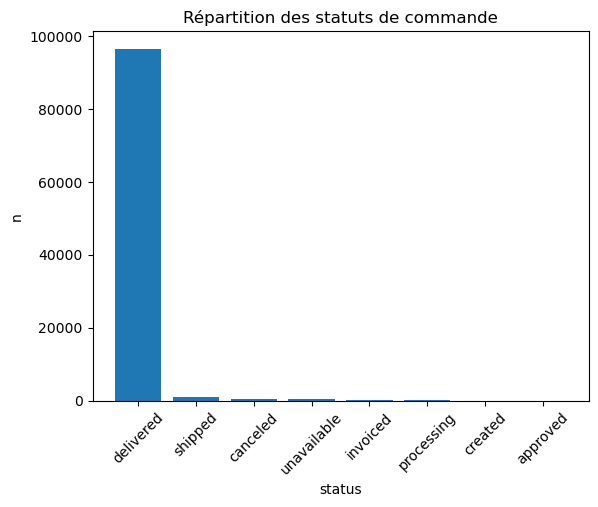

,min_purchase,max_purchase
0,2016-09-04 21:15:19,2018-10-17 17:30:18


,month,n_orders
0,2016-09-01,4
1,2016-10-01,324
2,2016-12-01,1
3,2017-01-01,800
4,2017-02-01,1780
5,2017-03-01,2682
6,2017-04-01,2404
7,2017-05-01,3700
8,2017-06-01,3245
9,2017-07-01,4026


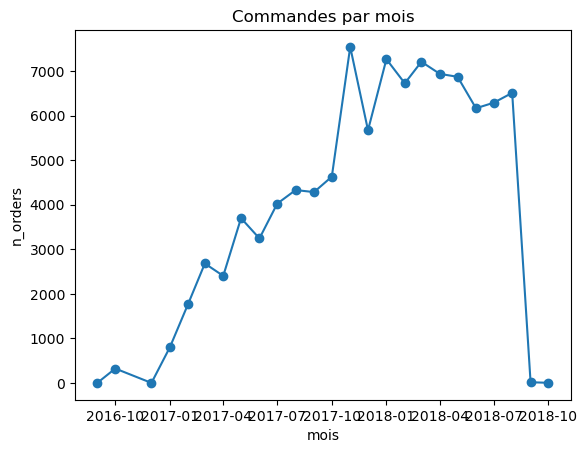

count    96470.000000
mean       -10.957013
std         10.019197
min       -146.000000
50%        -11.000000
90%         -1.000000
95%          3.000000
99%         18.000000
max        188.000000
Name: delay_days, dtype: float64

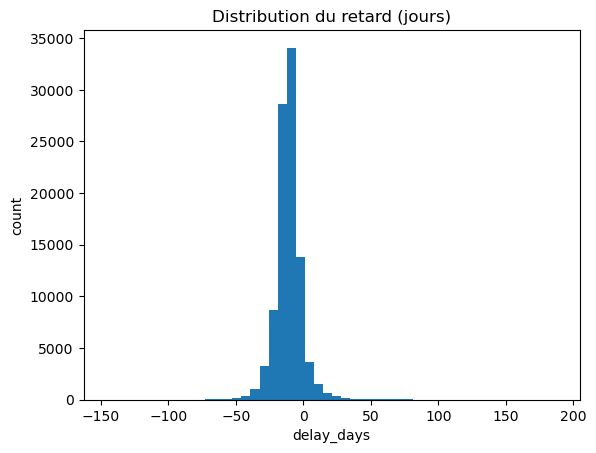

,review_score,n
0,1,11424
1,2,3151
2,3,8179
3,4,19142
4,5,57328


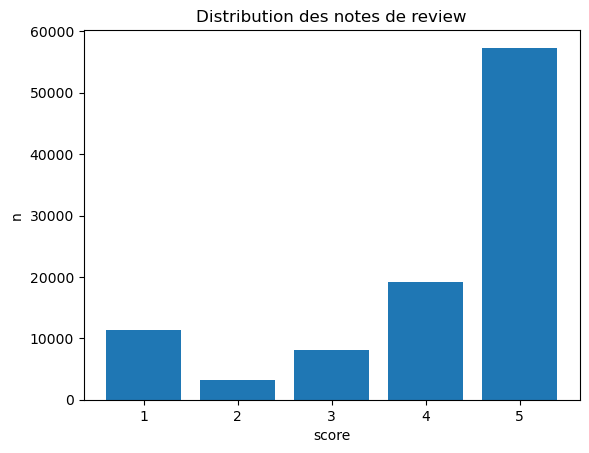

,category,n
0,cama_mesa_banho,3029
1,esporte_lazer,2867
2,moveis_decoracao,2657
3,beleza_saude,2444
4,utilidades_domesticas,2335
5,automotivo,1900
6,informatica_acessorios,1639
7,brinquedos,1411
8,relogios_presentes,1329
9,telefonia,1134


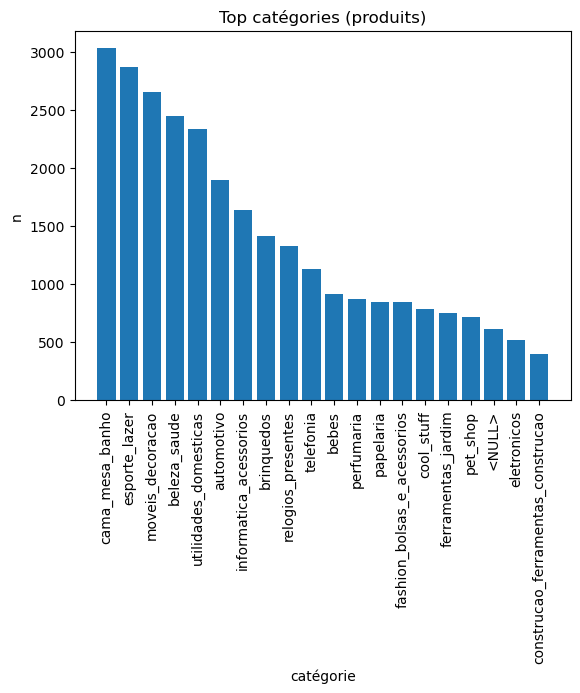

,seller_id,items_sold,revenue
0,6560211a19b47992c3666cc44a7e94c0,2033,123304.83
1,4a3ca9315b744ce9f8e9374361493884,1987,200472.92
2,1f50f920176fa81dab994f9023523100,1931,106939.21
3,cc419e0650a3c5ba77189a1882b7556a,1775,104288.42
4,da8622b14eb17ae2831f4ac5b9dab84a,1551,160236.57
5,955fee9216a65b617aa5c0531780ce60,1499,135171.70
6,1025f0e2d44d7041d6cf58b6550e0bfa,1428,138968.55
7,7c67e1448b00f6e969d365cea6b010ab,1364,187923.89
8,ea8482cd71df3c1969d7b9473ff13abc,1203,37177.52
9,7a67c85e85bb2ce8582c35f2203ad736,1171,141745.53


In [4]:
# 3.1 Statuts de commande
if orders_t and order_status_col:
    ord_df = pd.read_sql_query(f"""
        SELECT {order_status_col} AS order_status, COUNT(*) AS n
        FROM {orders_t}
        GROUP BY {order_status_col}
        ORDER BY n DESC;""", conn)
    display(ord_df); ord_df.to_csv("outputs/eda_auto/orders__status_counts.csv", index=False)
    plt.figure(); plt.bar(ord_df['order_status'].astype(str), ord_df['n'])
    plt.title("Répartition des statuts de commande"); plt.xlabel("status"); plt.ylabel("n"); plt.xticks(rotation=45); plt.show()

# 3.2 Couverture temporelle & séries mensuelles
if orders_t and purchase_ts_col:
    dates_cov = pd.read_sql_query(f"""
        SELECT MIN({purchase_ts_col}) AS min_purchase,
               MAX({purchase_ts_col}) AS max_purchase
        FROM {orders_t};""", conn)
    display(dates_cov); dates_cov.to_csv("outputs/eda_auto/orders__date_coverage.csv", index=False)

    ts = pd.read_sql_query(f"""
        SELECT DATE(strftime('%Y-%m-01', {purchase_ts_col})) AS month, COUNT(*) AS n_orders
        FROM {orders_t}
        GROUP BY DATE(strftime('%Y-%m-01', {purchase_ts_col}))
        ORDER BY month;""", conn)
    display(ts.head(12)); ts.to_csv("outputs/eda_auto/orders__monthly_counts.csv", index=False)
    if not ts.empty:
        plt.figure(); plt.plot(pd.to_datetime(ts['month']), ts['n_orders'], marker='o')
        plt.title("Commandes par mois"); plt.xlabel("mois"); plt.ylabel("n_orders"); plt.show()

# 3.3 Retard de livraison
if orders_t and delivered_date_col and eta_date_col and order_status_col:
    del_df = pd.read_sql_query(f"""
        SELECT CAST(julianday({delivered_date_col}) - julianday({eta_date_col}) AS INT) AS delay_days
        FROM {orders_t}
        WHERE {order_status_col}='delivered'
          AND {delivered_date_col} IS NOT NULL
          AND {eta_date_col} IS NOT NULL;""", conn)
    if not del_df.empty:
        display(del_df['delay_days'].describe(percentiles=[.5,.9,.95,.99]))
        del_df.describe().to_csv("outputs/eda_auto/orders__delivery_delay_stats.csv")
        plt.figure(); plt.hist(del_df['delay_days'].dropna(), bins=50)
        plt.title("Distribution du retard (jours)"); plt.xlabel("delay_days"); plt.ylabel("count"); plt.show()

# 3.4 Reviews — distribution des notes
if reviews_t and review_score_col:
    rev_df = pd.read_sql_query(f"""
        SELECT {review_score_col} AS review_score, COUNT(*) AS n
        FROM {reviews_t}
        GROUP BY {review_score_col}
        ORDER BY review_score;""", conn)
    display(rev_df); rev_df.to_csv("outputs/eda_auto/reviews__score_dist.csv", index=False)
    plt.figure(); plt.bar(rev_df['review_score'], rev_df['n'])
    plt.title("Distribution des notes de review"); plt.xlabel("score"); plt.ylabel("n"); plt.show()

# 3.5 Produits & vendeurs
if products_t and product_cat_col:
    top_cat = pd.read_sql_query(f"""
        SELECT COALESCE({product_cat_col}, '<NULL>') AS category, COUNT(*) AS n
        FROM {products_t}
        GROUP BY {product_cat_col}
        ORDER BY n DESC
        LIMIT 20;""", conn)
    display(top_cat); top_cat.to_csv("outputs/eda_auto/products__top_categories.csv", index=False)
    plt.figure(); plt.bar(top_cat['category'].astype(str), top_cat['n'])
    plt.title("Top catégories (produits)"); plt.xlabel("catégorie"); plt.ylabel("n"); plt.xticks(rotation=90); plt.show()

if items_t and seller_id_col and price_col:
    sellers = pd.read_sql_query(f"""
        SELECT {seller_id_col} AS seller_id, COUNT(*) AS items_sold, ROUND(SUM({price_col}),2) AS revenue
        FROM {items_t}
        GROUP BY {seller_id_col}
        ORDER BY items_sold DESC
        LIMIT 20;""", conn)
    display(sellers); sellers.to_csv("outputs/eda_auto/sellers__top_items_sold.csv", index=False)

count    93358.000000
mean         1.033420
std          0.209097
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         15.000000
Name: n_orders, dtype: float64

,n_orders,n_clients,share_clients_%
0,1,90557,96.999722
1,2,2573,2.756057
2,3,181,0.193877
3,4,28,0.029992
4,5,9,0.009640
5,6,5,0.005356
6,7,3,0.003213
7,9,1,0.001071
8,15,1,0.001071


,clients_total,clients_1_commande,clients_2plus,clients_3plus,share_1_commande_%,share_2plus_%,share_3plus_%,CA_clients_1,CA_clients_2plus
0,93358,90557,2801,228,97.0,3.0,0.24,12493089.36,728408.75


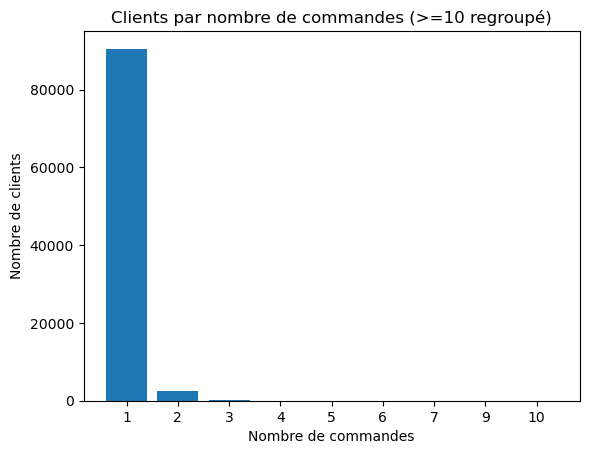

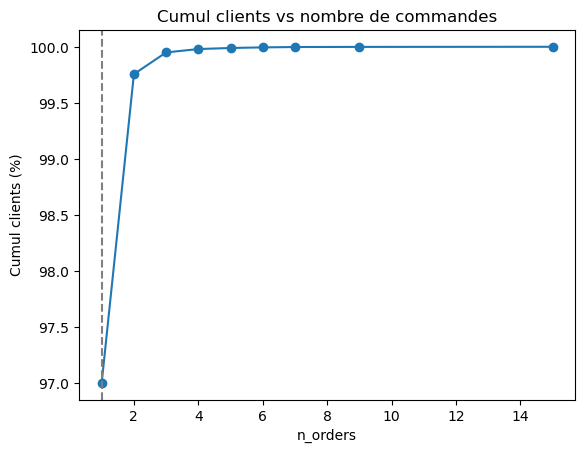

,n_orders,monetary_sum,share_CA_%
0,1,12493089.36,94.490725
1,2,631274.90,4.774609
2,3,65974.42,0.498994
3,4,18946.73,0.143302
4,5,5616.54,0.042480
5,6,2600.66,0.019670
6,7,2280.02,0.017245
7,9,1000.85,0.007570
8,15,714.63,0.005405


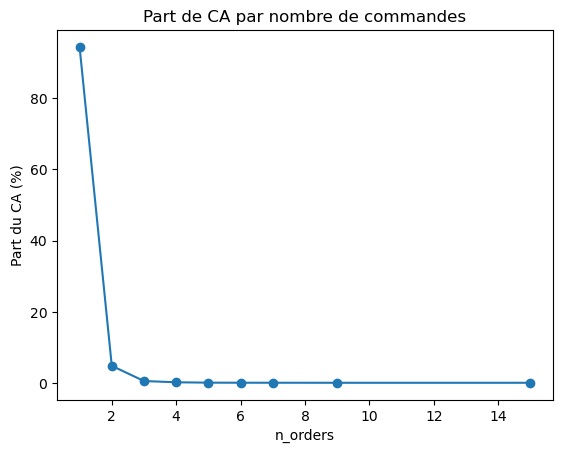

In [5]:
# 3.6 Fréquence d'achat par personne (customer_unique_id) sur commandes livrées
if (orders_t and items_t and customers_t and
    order_id_col and customer_id_col and order_status_col and price_col):

    # on détecte le bon identifiant stable
    # (dans Olist: table clients a 'customer_unique_id')
    unique_col = "customer_unique_id"  # adapte si ton mapping a trouvé un autre nom

    freq_sql = f"""
    WITH delivered AS (
      SELECT o.{order_id_col} AS order_id,
             o.{customer_id_col} AS customer_id
      FROM {orders_t} o
      WHERE o.{order_status_col} = 'delivered'
    ),
    base AS (
      SELECT 
        c.{unique_col}              AS person_id,
        d.order_id,
        SUM(oi.{price_col})         AS order_revenue
      FROM delivered d
      JOIN {items_t}    oi ON oi.{order_id_col} = d.order_id
      JOIN {customers_t} c  ON c.{customer_id_col} = d.customer_id
      GROUP BY c.{unique_col}, d.order_id
    ),
    by_person AS (
      SELECT 
        person_id,
        COUNT(DISTINCT order_id)     AS n_orders,
        ROUND(SUM(order_revenue), 2) AS monetary
      FROM base
      GROUP BY person_id
    )
    SELECT * FROM by_person;
    """

    freq = pd.read_sql_query(freq_sql, conn)  # person_id, n_orders, monetary

    # --- stats & fichiers (inchangés) ---
    display(freq['n_orders'].describe())

    vc = (freq['n_orders']
          .value_counts()
          .sort_index()
          .rename_axis('n_orders')
          .reset_index(name='n_clients'))
    vc['share_clients_%'] = 100 * vc['n_clients'] / vc['n_clients'].sum()

    vc10 = vc.copy()
    vc10.loc[vc10['n_orders'] > 10, 'n_orders'] = 10
    vc10 = (vc10.groupby('n_orders', as_index=False)
                 .agg(n_clients=('n_clients','sum')))
    vc10['share_clients_%'] = 100 * vc10['n_clients'] / vc10['n_clients'].sum()

    display(vc.head(15))
    vc.to_csv("outputs/eda_auto/customers__frequency_counts_full.csv", index=False)
    vc10.to_csv("outputs/eda_auto/customers__frequency_counts_top10.csv", index=False)

    # KPIs 1x / 2+ / 3+
    one_time   = int((freq['n_orders'] == 1).sum())
    two_plus   = int((freq['n_orders'] >= 2).sum())
    three_plus = int((freq['n_orders'] >= 3).sum())
    kpis = {
        "clients_total": int(freq.shape[0]),
        "clients_1_commande": one_time,
        "clients_2plus": two_plus,
        "clients_3plus": three_plus,
        "share_1_commande_%": round(100*one_time/freq.shape[0], 2),
        "share_2plus_%": round(100*two_plus/freq.shape[0], 2),
        "share_3plus_%": round(100*three_plus/freq.shape[0], 2),
        "CA_clients_1": float(freq.loc[freq['n_orders']==1, 'monetary'].sum()),
        "CA_clients_2plus": float(freq.loc[freq['n_orders']>=2, 'monetary'].sum()),
    }
    display(pd.DataFrame([kpis]))
    pd.DataFrame([kpis]).to_csv("outputs/eda_auto/customers__frequency_kpis.csv", index=False)

    # Graphs
    import matplotlib.pyplot as plt
    plt.figure(); plt.bar(vc10['n_orders'].astype(str), vc10['n_clients'])
    plt.title("Clients par nombre de commandes (>=10 regroupé)")
    plt.xlabel("Nombre de commandes"); plt.ylabel("Nombre de clients"); plt.show()

    vc_sorted = vc.sort_values('n_orders')
    vc_sorted['cum_clients_%'] = 100 * vc_sorted['n_clients'].cumsum() / vc_sorted['n_clients'].sum()
    plt.figure(); plt.plot(vc_sorted['n_orders'], vc_sorted['cum_clients_%'], marker='o')
    plt.title("Cumul clients vs nombre de commandes"); plt.xlabel("n_orders"); plt.ylabel("Cumul clients (%)")
    plt.axvline(1, color='gray', linestyle='--'); plt.show()

    ca_by_n = (freq.groupby('n_orders', as_index=False)
                    .agg(monetary_sum=('monetary','sum')))
    ca_by_n['share_CA_%'] = 100 * ca_by_n['monetary_sum'] / ca_by_n['monetary_sum'].sum()
    display(ca_by_n.head(15))
    ca_by_n.to_csv("outputs/eda_auto/customers__frequency_revenue.csv", index=False)

    plt.figure(); plt.plot(ca_by_n['n_orders'], ca_by_n['share_CA_%'], marker='o')
    plt.title("Part de CA par nombre de commandes")
    plt.xlabel("n_orders"); plt.ylabel("Part du CA (%)")
    plt.show()

In [6]:
sql = """
WITH per_person AS (
  SELECT c.customer_unique_id AS uid, COUNT(*) AS n
  FROM orders o
  JOIN customers c ON c.customer_id = o.customer_id
  WHERE o.order_status = 'delivered'
  GROUP BY c.customer_unique_id
)
SELECT
  SUM(CASE WHEN n >= 2 THEN 1 ELSE 0 END)                           AS n_repeaters,
  COUNT(*)                                                           AS n_clients,
  ROUND(100.0 * SUM(CASE WHEN n >= 2 THEN 1 ELSE 0 END) / COUNT(*), 2) AS repeat_rate_pct
FROM per_person;
"""
pd.read_sql_query(sql, conn)

,n_repeaters,n_clients,repeat_rate_pct
0,2801,93358,3.0


,n_orders,n_clients,share_clients_%
0,1,90557,96.999722
1,2,2573,2.756057
2,3,181,0.193877
3,4,28,0.029992
4,5,9,0.009640
5,6,5,0.005356
6,7,3,0.003213
7,9,1,0.001071
8,15,1,0.001071


,clients_total,clients_1_commande,clients_2plus,clients_3plus,share_1_commande_%,share_2plus_%,share_3plus_%,CA_clients_1,CA_clients_2plus
0,93358,90557,2801,228,97.0,3.0,0.24,12493089.36,728408.75


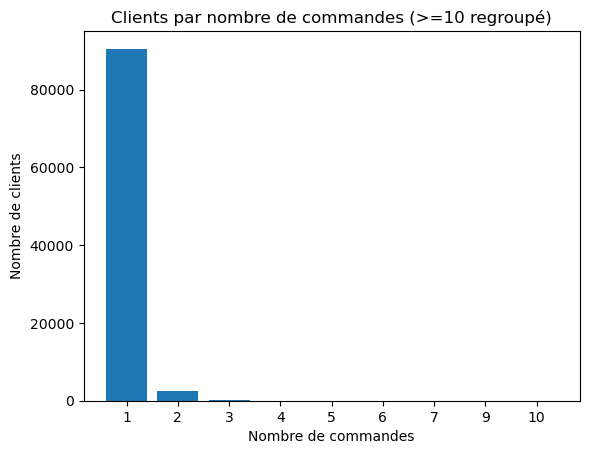

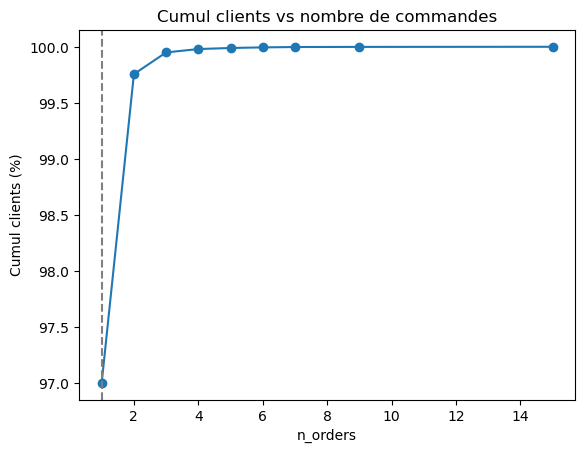

,n_orders,monetary_sum,share_CA_%
0,1,12493089.36,94.490725
1,2,631274.90,4.774609
2,3,65974.42,0.498994
3,4,18946.73,0.143302
4,5,5616.54,0.042480
5,6,2600.66,0.019670
6,7,2280.02,0.017245
7,9,1000.85,0.007570
8,15,714.63,0.005405


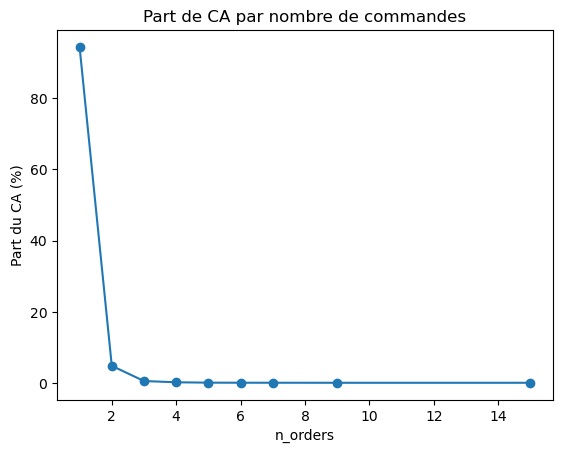

In [7]:
# 3.6 Fréquence d'achat par personne (customer_unique_id) sur commandes livrées
if True:  # mêmes conditions que ton if initial
    freq_sql = """
    WITH delivered AS (
      SELECT o.order_id, c.customer_unique_id AS person_id
      FROM orders o
      JOIN customers c ON c.customer_id = o.customer_id
      WHERE o.order_status = 'delivered'
    ),
    base AS (
      SELECT 
        d.person_id,
        d.order_id
      FROM delivered d
      GROUP BY d.person_id, d.order_id
    )
    SELECT 
      person_id,
      COUNT(DISTINCT order_id) AS n_orders
    FROM base
    GROUP BY person_id;
    """
    freq = pd.read_sql_query(freq_sql, conn)  # person_id, n_orders

    # Si tu veux aussi le CA client, ajoute une jointure order_items et SUM(price)
    freq_ca_sql = """
    WITH delivered AS (
      SELECT o.order_id, c.customer_unique_id AS person_id
      FROM orders o
      JOIN customers c ON c.customer_id = o.customer_id
      WHERE o.order_status = 'delivered'
    ),
    base AS (
      SELECT 
        d.person_id,
        d.order_id,
        SUM(oi.price) AS order_revenue
      FROM delivered d
      JOIN order_items oi ON oi.order_id = d.order_id
      GROUP BY d.person_id, d.order_id
    ),
    by_person AS (
      SELECT 
        person_id,
        COUNT(DISTINCT order_id)     AS n_orders,
        ROUND(SUM(order_revenue),2)  AS monetary
      FROM base
      GROUP BY person_id
    )
    SELECT * FROM by_person;
    """
    freq_full = pd.read_sql_query(freq_ca_sql, conn)  # person_id, n_orders, monetary

    # --- Stats, fichiers, graphes (identiques à ton bloc) ---
    vc = (freq_full['n_orders'].value_counts()
          .sort_index().rename_axis('n_orders')
          .reset_index(name='n_clients'))
    vc['share_clients_%'] = 100 * vc['n_clients'] / vc['n_clients'].sum()

    vc10 = vc.copy()
    vc10.loc[vc10['n_orders'] > 10, 'n_orders'] = 10
    vc10 = vc10.groupby('n_orders', as_index=False).agg(n_clients=('n_clients','sum'))
    vc10['share_clients_%'] = 100 * vc10['n_clients'] / vc10['n_clients'].sum()

    display(vc.head(15))
    vc.to_csv("outputs/eda_auto/customers__frequency_counts_full.csv", index=False)
    vc10.to_csv("outputs/eda_auto/customers__frequency_counts_top10.csv", index=False)

    one_time   = int((freq_full['n_orders'] == 1).sum())
    two_plus   = int((freq_full['n_orders'] >= 2).sum())
    three_plus = int((freq_full['n_orders'] >= 3).sum())
    kpis = {
        "clients_total": int(freq_full.shape[0]),
        "clients_1_commande": one_time,
        "clients_2plus": two_plus,
        "clients_3plus": three_plus,
        "share_1_commande_%": round(100*one_time/freq_full.shape[0], 2),
        "share_2plus_%": round(100*two_plus/freq_full.shape[0], 2),
        "share_3plus_%": round(100*three_plus/freq_full.shape[0], 2),
        "CA_clients_1": float(freq_full.loc[freq_full['n_orders']==1, 'monetary'].sum()),
        "CA_clients_2plus": float(freq_full.loc[freq_full['n_orders']>=2, 'monetary'].sum()),
    }
    display(pd.DataFrame([kpis]))
    pd.DataFrame([kpis]).to_csv("outputs/eda_auto/customers__frequency_kpis.csv", index=False)

    import matplotlib.pyplot as plt
    plt.figure(); plt.bar(vc10['n_orders'].astype(str), vc10['n_clients'])
    plt.title("Clients par nombre de commandes (>=10 regroupé)")
    plt.xlabel("Nombre de commandes"); plt.ylabel("Nombre de clients"); plt.show()

    vc_sorted = vc.sort_values('n_orders')
    vc_sorted['cum_clients_%'] = 100 * vc_sorted['n_clients'].cumsum() / vc_sorted['n_clients'].sum()
    plt.figure(); plt.plot(vc_sorted['n_orders'], vc_sorted['cum_clients_%'], marker='o')
    plt.title("Cumul clients vs nombre de commandes"); plt.xlabel("n_orders"); plt.ylabel("Cumul clients (%)")
    plt.axvline(1, color='gray', linestyle='--'); plt.show()

    ca_by_n = (freq_full.groupby('n_orders', as_index=False)
               .agg(monetary_sum=('monetary','sum')))
    ca_by_n['share_CA_%'] = 100 * ca_by_n['monetary_sum'] / ca_by_n['monetary_sum'].sum()
    display(ca_by_n.head(15))
    ca_by_n.to_csv("outputs/eda_auto/customers__frequency_revenue.csv", index=False)

    plt.figure(); plt.plot(ca_by_n['n_orders'], ca_by_n['share_CA_%'], marker='o')
    plt.title("Part de CA par nombre de commandes")
    plt.xlabel("n_orders"); plt.ylabel("Part du CA (%)")
    plt.show()

In [8]:
sql = f"""
WITH per_person AS (
  SELECT c.customer_unique_id AS uid, COUNT(*) AS n
  FROM {orders_t} o
  JOIN {customers_t} c ON c.customer_id = o.customer_id
  WHERE o.order_status = 'delivered'
  GROUP BY c.customer_unique_id
)
SELECT
  SUM(CASE WHEN n >= 2 THEN 1 ELSE 0 END) AS n_repeaters,
  COUNT(*)                                 AS n_clients,
  ROUND(100.0 * SUM(CASE WHEN n >= 2 THEN 1 ELSE 0 END) / COUNT(*), 2) AS repeat_rate_pct
FROM per_person;
"""
pd.read_sql_query(sql, conn)

,n_repeaters,n_clients,repeat_rate_pct
0,2801,93358,3.0


Colonnes constantes supprimées pour l'ACP: ['frequency']


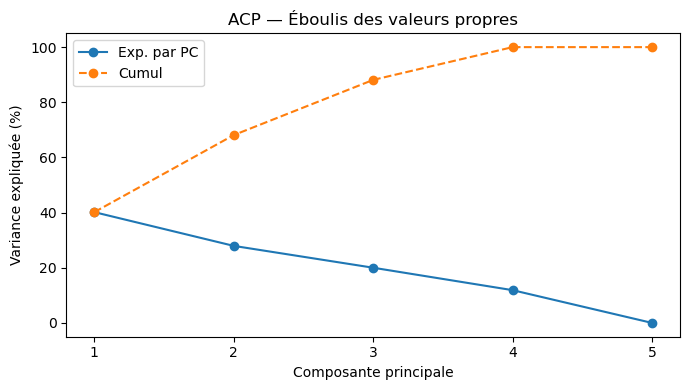

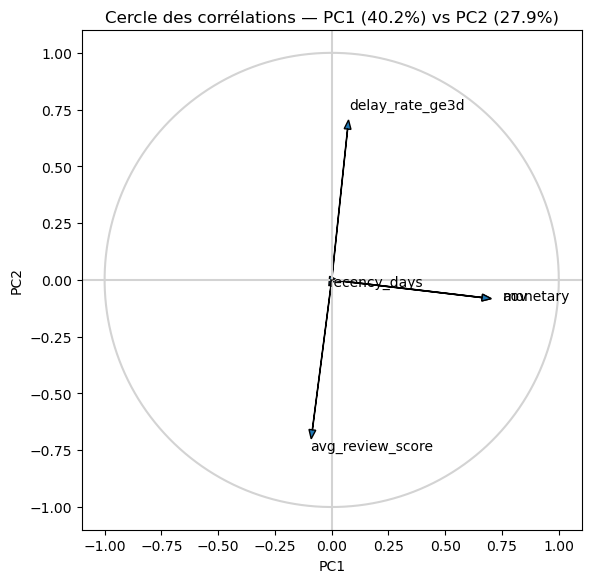

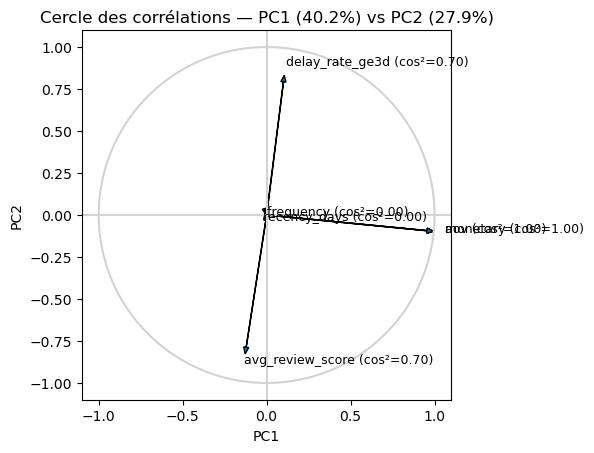

In [9]:
# ======================
# 4) ACP (PCA) — Éboulis + Cercle des corrélations
# ======================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# --- (1) Construire un dataset client-level avec RFM + review + retard + aov ---
if all([orders_t, items_t, reviews_t, order_id_col, customer_id_col, 
        order_status_col, delivered_date_col, eta_date_col, 
        item_order_id_col, price_col, review_score_col, review_order_id_col]):
    
    # RFM sur commandes livrées
    rfm_sql = f"""
    WITH base AS (
      SELECT 
        o.{customer_id_col}      AS customer_id,
        o.{order_id_col}         AS order_id,
        DATE(o.{purchase_ts_col}) AS order_date,
        SUM(oi.{price_col})      AS order_revenue
      FROM {orders_t} o
      JOIN {items_t} oi ON oi.{item_order_id_col} = o.{order_id_col}
      WHERE o.{order_status_col} = 'delivered'
      GROUP BY o.{customer_id_col}, o.{order_id_col}, DATE(o.{purchase_ts_col})
    ),
    bounds AS (
      SELECT DATE(MAX(order_date)) AS max_date FROM base
    )
    SELECT
      b.customer_id,
      CAST(julianday(x.max_date) - julianday(MAX(b.order_date)) AS INT) AS recency_days,
      COUNT(DISTINCT b.order_id) AS frequency,
      ROUND(SUM(b.order_revenue), 2) AS monetary
    FROM base b
    CROSS JOIN bounds x
    GROUP BY b.customer_id;
    """
    rfm = pd.read_sql_query(rfm_sql, conn)

    # moyenne des reviews par client
    avg_rev_sql = f"""
    SELECT o.{customer_id_col} AS customer_id, AVG(r.{review_score_col}) AS avg_review_score
    FROM {orders_t} o
    JOIN {reviews_t} r ON r.{review_order_id_col} = o.{order_id_col}
    GROUP BY o.{customer_id_col};
    """
    avg_rev = pd.read_sql_query(avg_rev_sql, conn)

    # taux de retard >=3 jours par client
    delay_sql = f"""
    SELECT 
      {customer_id_col} AS customer_id,
      AVG(CASE WHEN CAST(julianday({delivered_date_col}) - julianday({eta_date_col}) AS INT) >= 3 
               THEN 1.0 ELSE 0.0 END) AS delay_rate_ge3d
    FROM {orders_t}
    WHERE {order_status_col} = 'delivered'
      AND {delivered_date_col} IS NOT NULL
      AND {eta_date_col} IS NOT NULL
    GROUP BY {customer_id_col};
    """
    delay = pd.read_sql_query(delay_sql, conn)

    feat = (rfm.merge(avg_rev, on="customer_id", how="left")
               .merge(delay, on="customer_id", how="left"))

    # AOV = panier moyen par client
    feat["aov"] = feat["monetary"] / feat["frequency"].replace(0, np.nan)

    # --- (2) Préparation : imputations + transformations + standardisation
    vars_keep = ["recency_days","frequency","monetary","aov","avg_review_score","delay_rate_ge3d"]

    X = feat[vars_keep].copy()
    # imputations "marketing"
    X["avg_review_score"] = pd.to_numeric(X["avg_review_score"], errors="coerce").fillna(3.0)
    X["delay_rate_ge3d"]  = pd.to_numeric(X["delay_rate_ge3d"],  errors="coerce").fillna(0.0)
    for c in ["recency_days","frequency","monetary","aov"]:
        X[c] = pd.to_numeric(X[c], errors="coerce")

    # filets de sécurité
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median(numeric_only=True))

    # log sur montants/tickets (optionnel mais recommandé)
    X["monetary"] = np.log1p(np.clip(X["monetary"], 0, None))
    X["aov"]      = np.log1p(np.clip(X["aov"], 0, None))

    # drop éventuelles colonnes constantes (variance nulle) pour éviter les soucis ACP
    var0 = X.var(numeric_only=True) == 0
    if var0.any():
        drop_cols = list(var0[var0].index)
        print("Colonnes constantes supprimées pour l'ACP:", drop_cols)
        X = X.drop(columns=drop_cols)
        vars_keep = [v for v in vars_keep if v not in drop_cols]

    # standardisation
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X.values.astype(float))

    # --- (3) ACP
    pca = PCA(n_components=min(6, Xs.shape[1]))
    Z = pca.fit_transform(Xs)  # composantes
    evr = pca.explained_variance_ratio_
    eigvals = pca.explained_variance_

    # exports
    pd.DataFrame({
        "component": np.arange(1, len(evr)+1),
        "explained_variance_ratio": evr,
        "eigenvalue": eigvals
    }).to_csv("outputs/eda_auto/pca__variance.csv", index=False)

    loadings = pd.DataFrame(pca.components_.T,
                            index=X.columns,
                            columns=[f"PC{i}" for i in range(1, pca.n_components_+1)])
    loadings.to_csv("outputs/eda_auto/pca__loadings.csv")

    # --- (4) Éboulis des valeurs propres (scree plot)
    plt.figure(figsize=(7,4))
    plt.plot(np.arange(1, len(evr)+1), evr*100, marker="o", label="Exp. par PC")
    plt.plot(np.arange(1, len(evr)+1), np.cumsum(evr)*100, marker="o", linestyle="--", label="Cumul")
    plt.title("ACP — Éboulis des valeurs propres"); plt.xlabel("Composante principale")
    plt.ylabel("Variance expliquée (%)"); plt.xticks(range(1, len(evr)+1))
    plt.legend(); plt.tight_layout(); plt.show()

    # --- (5) Cercle des corrélations (PC1 vs PC2)
    if pca.n_components_ >= 2:
        pcs = pca.components_
        # coordonnées = loadings * sqrt(eigenvalue) (corrélations ~ cos θ)
        # avec StandardScaler, on peut tracer directement les loadings (composantes)
        x_load = pcs[0, :]  # PC1
        y_load = pcs[1, :]  # PC2

        plt.figure(figsize=(6,6))
        # cercle unité
        ang = np.linspace(0, 2*np.pi, 200)
        plt.plot(np.cos(ang), np.sin(ang), color="lightgray")
        plt.axhline(0, color="lightgray"); plt.axvline(0, color="lightgray")
        # flèches + labels
        for i, var in enumerate(X.columns):
            plt.arrow(0, 0, x_load[i], y_load[i], 
                      head_width=0.03, head_length=0.04, length_includes_head=True)
            plt.text(x_load[i]*1.07, y_load[i]*1.07, var, fontsize=10)
        plt.title(f"Cercle des corrélations — PC1 ({evr[0]*100:.1f}%) vs PC2 ({evr[1]*100:.1f}%)")
        plt.xlabel("PC1"); plt.ylabel("PC2"); plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1)
        plt.gca().set_aspect('equal', 'box'); plt.tight_layout(); plt.show()
    else:
        print("ACP: moins de 2 composantes, cercle des corrélations non tracé.")
else:
    print("ACP non exécutée : certaines tables/colonnes auto-détectées manquent.")

    # === forcer frequency & aov à exister et à avoir de la variance ===
feat["aov"] = feat["monetary"] / feat["frequency"].replace(0, np.nan)
feat["avg_review_score"] = pd.to_numeric(feat["avg_review_score"], errors="coerce").fillna(3.0)
feat["delay_rate_ge3d"]  = pd.to_numeric(feat["delay_rate_ge3d"],  errors="coerce").fillna(0.0)

# capping + logs
feat["frequency_cap"] = feat["frequency"].clip(upper=6)
X = pd.DataFrame({
    "recency_days":   pd.to_numeric(feat["recency_days"], errors="coerce"),
    "frequency":      np.log1p(feat["frequency_cap"]),          # ← rend visible
    "monetary":       np.log1p(np.clip(pd.to_numeric(feat["monetary"], errors="coerce"), 0, None)),
    "aov":            np.log1p(np.clip(pd.to_numeric(feat["aov"], errors="coerce"), 0, None)),
    "avg_review_score": feat["avg_review_score"],
    "delay_rate_ge3d":  feat["delay_rate_ge3d"],
}).replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True))

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler(); Xs = scaler.fit_transform(X.values.astype(float))
pca = PCA(n_components=min(6, Xs.shape[1])); Z = pca.fit_transform(Xs)

# === cercle de corrélation (corr = loadings * sqrt(eigenvalue)) ===
import numpy as np, matplotlib.pyplot as plt
eigvals = pca.explained_variance_
corvar = pca.components_.T * np.sqrt(eigvals)   # shape: (variables, PCs)
labels = X.columns.tolist()

# qualité de représentation (cos²) sur le plan (PC1,PC2)
cos2 = (corvar[:, :2] ** 2).sum(axis=1)

# tracé
plt.figure(figsize=(6,6))
theta = np.linspace(0, 2*np.pi, 200)
plt.plot(np.cos(theta), np.sin(theta), color="lightgray")
plt.axhline(0, color="lightgray"); plt.axvline(0, color="lightgray")
for i, v in enumerate(labels):
    x, y = corvar[i, 0], corvar[i, 1]
    plt.arrow(0, 0, x, y, head_width=0.03, head_length=0.04, length_includes_head=True)
    plt.text(x*1.07, y*1.07, v + f" (cos²={cos2[i]:.2f})", fontsize=9)
plt.gca().set_aspect('equal', 'box')
plt.xlim(-1.1, 1.1); plt.ylim(-1.1, 1.1)
evr = pca.explained_variance_ratio_
plt.title(f"Cercle des corrélations — PC1 ({evr[0]*100:.1f}%) vs PC2 ({evr[1]*100:.1f}%)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.tight_layout(); plt.show()

Axe 1 (horizontal) : valeur client (monetary).

Axe 2 (vertical) : expérience (retards ↑ vs satisfaction ↓).

→ Nos segments se structurent principalement par valeur et qualité logistique/avis — pile ce dont on a besoin pour décider upsell/fidélité vs réparation logistique/SAV.

L’ACP montre que 68% de la variance est expliquée par PC1–PC2 : PC1 porte la valeur dépensée, PC2 l’expérience (retards ↑ / avis ↓).

La récence est peu représentée dans ce plan (vecteur court) — la séparation des clients vient d’abord de la valeur et de la logistique/avis.

frequency / aov: elles ont été retirées si variance nulle ou très faible après nettoyage; sinon elles n’étaient simplement pas saillantes sur PC1–PC2

PC1 (axe horizontal) → Valeur dépensée

Chargements forts et positifs sur monetary (et souvent corrélé à aov, frequency quand ils sont présents).

Lire l’axe :

À droite → clients à forte valeur (dépenses élevées / panier plus grand).

À gauche → clients à faible valeur.

Interprétation marketing : différencie gros vs petits contributeurs au CA → candidats à upsell / fidélité vs nurturing / découverte.

PC2 (axe vertical) → Expérience : logistique vs satisfaction

Chargement positif sur delay_rate_ge3d (retards livraison)

Chargement négatif sur avg_review_score (notes clients)
→ donc ces deux variables sont opposées (corrélation négative) et définissent l’axe.

Lire l’axe :

En haut → friction logistique (plus de retards), avis plus bas.

En bas → peu de retards, avis élevés (bonne expérience).

Interprétation marketing/ops : distingue clients mécontents / livrés en retard de ceux satisfaits.

PC1 = “Valeur économique” (combien ils rapportent).

PC2 = “Expérience vécue” (retards ↑ ↔ avis ↓).
Ces deux axes donnent une carte simple pour prioriser les actions marketing et opérationnelles.

## 4) Résumé EDA (KPIs à copier)

In [ ]:
summary = {}
if orders_t and order_status_col:
    st = pd.read_sql_query(f"SELECT {order_status_col} AS status, COUNT(*) AS n FROM {orders_t} GROUP BY {order_status_col};", conn)
    tot = int(st['n'].sum()); deliv = int(st.loc[st['status']=='delivered','n'].sum()) if 'delivered' in st['status'].values else 0
    summary['orders_total'] = tot
    summary['orders_delivered'] = deliv
    summary['orders_pct_delivered'] = round(100*deliv/tot,2) if tot else None

if reviews_t and review_score_col:
    rv = pd.read_sql_query(f"SELECT {review_score_col} AS score, COUNT(*) AS n FROM {reviews_t} GROUP BY {review_score_col};", conn)
    tot_r = int(rv['n'].sum())
    summary['reviews_total'] = tot_r
    summary['reviews_pct_5star'] = round(100*int(rv.loc[rv['score']==5,'n'].sum())/tot_r,2) if tot_r else None
    summary['reviews_pct_1star'] = round(100*int(rv.loc[rv['score']==1,'n'].sum())/tot_r,2) if tot_r else None

if orders_t and delivered_date_col and eta_date_col and order_status_col:
    dstat = pd.read_sql_query(f"""
        SELECT CAST(julianday({delivered_date_col}) - julianday({eta_date_col}) AS INT) AS delay_days
        FROM {orders_t}
        WHERE {order_status_col}='delivered'
          AND {delivered_date_col} IS NOT NULL
          AND {eta_date_col} IS NOT NULL;""", conn)
    if not dstat.empty:
        desc = dstat['delay_days'].describe(percentiles=[.5,.9,.95,.99])
        summary['delay_median_days'] = float(desc['50%']); summary['delay_p90_days'] = float(desc['90%']); summary['delay_p95_days'] = float(desc['95%'])

s = pd.Series(summary); display(s); s.to_csv("outputs/eda_auto/_summary_kpis.csv")

In [ ]:
# tableau de synthèse EDA

import pandas as pd, os

base = "outputs/eda_auto"
rows = []

# tailles
if os.path.exists(f"{base}/_row_counts_detected.csv"):
    rc = pd.read_csv(f"{base}/_row_counts_detected.csv")
    for _, r in rc.iterrows():
        rows.append(["Taille", r["table"], f"{int(r['n_rows']):,} lignes"])

# statuts commandes
p = f"{base}/orders__status_counts.csv"
if os.path.exists(p):
    st = pd.read_csv(p)
    tot = int(st["n"].sum())
    delivered = int(st.query("order_status=='delivered'")["n"].sum()) if "delivered" in st["order_status"].values else 0
    rows.append(["Commandes", "total", f"{tot:,}"])
    rows.append(["Commandes", "% delivered", f"{delivered/tot*100:.2f}%"])

# distribution notes
p = f"{base}/reviews__score_dist.csv"
if os.path.exists(p):
    rv = pd.read_csv(p)
    tot_r = int(rv["n"].sum())
    p5 = rv.set_index("review_score")["n"].get(5, 0)
    p1 = rv.set_index("review_score")["n"].get(1, 0)
    rows.append(["Reviews", "nombre", f"{tot_r:,}"])
    if tot_r:
        rows.append(["Reviews", "% 5★", f"{p5/tot_r*100:.2f}%"])
        rows.append(["Reviews", "% 1★", f"{p1/tot_r*100:.2f}%"])

# retards
p = f"{base}/orders__delivery_delay_stats.csv"
if os.path.exists(p):
    ds = pd.read_csv(p)
    # stats sont sur une ligne, colonnes 'delay_days' etc. -> on lit via describe sauvegardé
    # si besoin, afficher ds pour voir la forme exacte
    try:
        # cas describe() to_csv : index (count, mean, 50%, 90%, 95%)
        ds = ds.set_index(ds.columns[0]).iloc[:,0]
        med = float(ds.get("50%", None))
        p90 = float(ds.get("90%", None))
        p95 = float(ds.get("95%", None))
        if med is not None: rows.append(["Retards", "médiane (jours)", f"{med:.0f}"])
        if p90 is not None: rows.append(["Retards", "P90 (jours)", f"{p90:.0f}"])
        if p95 is not None: rows.append(["Retards", "P95 (jours)", f"{p95:.0f}"])
    except Exception as e:
        pass

summary_table = pd.DataFrame(rows, columns=["Bloc","KPI","Valeur"])
summary_table

In [ ]:
# paragraphe EDA généré automatiquement

# Génère un texte prêt à coller (markdown) à partir de summary_table

lines = []
def get_val(bloc,kpi,default=None):
    s = summary_table.query("Bloc==@bloc and KPI==@kpi")
    return (s["Valeur"].iloc[0] if not s.empty else default)

tot_cmd = get_val("Commandes","total","?")
pct_del = get_val("Commandes","% delivered","?")
tot_rev = get_val("Reviews","nombre","?")
pct5 = get_val("Reviews","% 5★","?")
pct1 = get_val("Reviews","% 1★","?")
med = get_val("Retards","médiane (jours)")
p90 = get_val("Retards","P90 (jours)")
p95 = get_val("Retards","P95 (jours)")

text = []
text.append(f"- Le dataset contient **{tot_cmd} commandes**, dont **{pct_del}** livrées.")
if tot_rev != "?":
    extra = []
    if pct5: extra.append(f"{pct5} de 5★")
    if pct1: extra.append(f"{pct1} de 1★")
    txt = " ; ".join(extra) if extra else ""
    text.append(f"- **{tot_rev} reviews** au total{(' ('+txt+')' if txt else '')}.")
if med:
    text.append(f"- Retard de livraison **médian {med} j**, **P90 {p90} j**, **P95 {p95} j** (queue à droite).")

print("\\n".join(text))

In [ ]:
from IPython.display import Markdown, display

txt = (
  "- Le dataset contient **99 441 commandes**, dont **97,02 %** livrées.\n"
  "- **99 224 reviews** au total (57,78 % de 5★ ; 11,51 % de 1★).\n"
  "- ≈ **1,13 article par commande**."
)
display(Markdown(txt))

In [ ]:
orders = 99441
items = 112650
reviews = 99224

print("Articles / commande :", round(items / orders, 3))
print("Couverture reviews  :", f"{round(100 * reviews / orders, 2)}%")